# DL Model Fit with Validation
* Test several loss functions and optimizers
* Use several metrics to compare
* Test on last data point
* Visualize loss and metrics
* Evaluate and predict on train set to try to foresee the result

__If any single HP has to be tuned, this should be the learning rate__. Good articles about learning rate:  
a) Theory: https://machinelearningmastery.com/learning-rate-for-deep-learning-neural-networks/  
b) Practice: https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/   
FINDING THE RIGHT LEARNING SHOULD A WHOLE SEPARATE EXPERIMENT OF ITS OWN

In [1]:
from copy import deepcopy
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import time
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM, Dropout, ConvLSTM2D, Flatten, TimeDistributed, RepeatVector
from keras.layers import LeakyReLU
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
from keras.layers import Activation
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adamax, Adam, Nadam, Ftrl
from keras.callbacks import LearningRateScheduler, EarlyStopping
from helper import ( prepare_data, train_test_shuffle_split, train_test_seq_split, print_folds_stats )
#from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import mean_squared_error as mse

from matplotlib import pyplot as plt
plt.style.use('ggplot')     # 'fivethirtyeight'
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# LOSSES
mse     = tf.keras.losses.MeanSquaredError()
mae     = tf.keras.losses.MeanAbsoluteError()
mape    = tf.keras.losses.MeanAbsolutePercentageError()
msle    = tf.keras.losses.MeanSquaredLogarithmicError()        # square(log(y_true + 1.) - log(y_pred + 1.))
huber   = tf.keras.losses.Huber()
logcosh = tf.keras.losses.LogCosh()

# METRICS
metric_mse   = tf.keras.metrics.MeanSquaredError()
metric_rmse  = tf.keras.metrics.RootMeanSquaredError()
metric_mae   = tf.keras.metrics.MeanAbsoluteError()
metric_mape  = tf.keras.metrics.MeanAbsolutePercentageError()
metric_msle  = tf.keras.metrics.MeanSquaredLogarithmicError()
metric_lcosh = tf.keras.metrics.LogCoshError()

In [3]:
# THESE GUYS SUPPOSEDLY HAVE IN-BUILT ADAPTIVE LRs
# IT IS RECOMMENDED TO KEEP THE DEFAULT HYPERPARAMETERS UNCHANGED (I saw confirmations of this with lower starting
# error scores for RMSprop)
# Adam is improved RMSprop which is improved Adadelta which is improved Adagrad (latter - aggressive adaptive decay)
# More details: https://keras.io/api/optimizers/

#keras.optimizers.Adagrad(  lr=0.01,  epsilon=1e-08, decay=0.0 )
#keras.optimizers.Adadelta( lr=1.0,   rho=0.95,      epsilon=1e-08, decay=0.0 )
#keras.optimizers.RMSprop(  lr=0.001, rho=0.9,       epsilon=1e-08, decay=0.0 )
#keras.optimizers.Adam(     lr=0.001, beta_1=0.9,    beta_2=0.999,  epsilon=1e-08, decay=0.0 )

In [4]:
# PREDICT ON ONE DATA POINT
def predict_one(model, X_last, loss_func=mse):
       
    X_last = X_last.reshape((1, n_steps, n_features))
    pred = model.predict(X_last, verbose=0)
    return np.round( pred[0] )

## Prepare data

In [5]:
df = pd.read_csv( 'data/2step_20210329.csv', encoding='utf-8' )
print('Shape of loaded data:', df.shape, '\n')

random_state      = 34
n_steps           = 10
features          = ['num1', 'num2', 'num3', 'num4']
n_features        = len(features)
n_output_features = len(features)
with_intersection = True
flatten           = False

( X,
  y,
  goldenx,
  goldeny )  = prepare_data( df,
                             features,
                             n_steps,
                             with_intersection=with_intersection,
                             flatten=flatten )

X_sh, y_sh = deepcopy(X), deepcopy(y)
X_sh, y_sh = shuffle( X_sh, y_sh, random_state=random_state, n_samples=None )

# shape changes to [1, n_features * n_step], but still need to keep n_output_features for output layer
if flatten:
    n_features = n_features * n_steps
    n_steps    = 1
    X = X.reshape(X.shape[0], n_steps, n_features)
    X_sh = X_sh.reshape(X.shape[0], n_steps, n_features)

Shape of loaded data: (2073, 8) 

Dropping 1 last row for golden data point
Data prepared:
	Size of X = (2062 by 10)
	Size of y = (2062 by 4)


In [6]:
# review data
idx = 1
print(f'X[{idx}]:', X[idx])
print(f'y[{idx}]:', y[idx])
df.head(25)

X[1]: [[30 34 23  4]
 [ 3 29 18 33]
 [23 35 28 17]
 [16 11 28  4]
 [32  4 28 34]
 [ 4  3 33  2]
 [21 10 31  6]
 [ 7 24 25 20]
 [30 25 16 23]
 [21 20 31  8]]
y[1]: [23  3 17 28]


,m,d,y,num1,num2,num3,num4,b
0,5,18,2001,9,10,22,13,1
1,5,22,2001,30,34,23,4,13
2,5,25,2001,3,29,18,33,17
3,5,29,2001,23,35,28,17,20
4,6,1,2001,16,11,28,4,31
5,6,5,2001,32,4,28,34,20
6,6,8,2001,4,3,33,2,29
7,6,12,2001,21,10,31,6,21
8,6,15,2001,7,24,25,20,35
9,6,19,2001,30,25,16,23,25


## Create model

In [7]:
def single_BiLSTM( n_steps, n_features,
                    learning_rate_=0.001,
                    units=750,
                    activation='relu',
                    dropout1=0,
                    dropout2=0,
                    dropout3=0,
                    optimizer=Adam,
                    loss=mse,
                    use_lr_decay=False,
                    metrics=[metric_mse],
                    print_architecture=False ):
    
    model = Sequential()
    model.add( Bidirectional( LSTM( units, activation=activation,
                                    dropout=dropout1,
                                    recurrent_dropout=dropout2,
                                    return_sequences=False),
                                                          
                              input_shape=(n_steps, n_features)
                            )
             )
        
    #model.add(Dropout( dropout3 ))
    model.add( Dense( n_output_features ) )
    
    # DO I NEED THIS?
    #if use_lr_decay:
    #    learning_rate = 0.0
    
    model.compile( optimizer=optimizer(learning_rate=learning_rate_),
                   loss=loss,
                   metrics=metrics )     # metrics=['mse'], optimizer=Adam(lr=learning_rate)
        
    if print_architecture:
        print(model.summary())
        
    return model

In [8]:
def stacked_BiLSTM( n_steps, n_features,
                    learning_rate_=0.001,
                    units=750,
                    activation='relu',
                    dropout1=0.2,
                    dropout2=0.2,
                    dropout3=0.2,
                    optimizer=Adam,
                    loss=mse,
                    use_lr_decay=False,
                    metrics=[metric_mse],
                    print_architecture=False ):
    
    model = Sequential()
    model.add( Bidirectional( LSTM( units, activation=activation,
                                    dropout=dropout1,
                                    recurrent_dropout=dropout2,
                                    return_sequences=True),
                                                          
                              input_shape=(n_steps, n_features)
                            )
             )
        
    model.add( Bidirectional( LSTM( units, activation=activation,
                                    dropout=dropout1,
                                    recurrent_dropout=dropout2) ) )
        
    #model.add(Dropout( dropout3 ))
    model.add( Dense( n_output_features ) )
    
    # DO I NEED THIS?
    if use_lr_decay:
        learning_rate = 0.0
    
    model.compile( optimizer=optimizer(learning_rate=learning_rate_),
                   loss=loss,
                   metrics=metrics )     # metrics=['mse'], optimizer=Adam(lr=learning_rate)
        
    if print_architecture:
        print(model.summary())
        
    return model

In [9]:
def stacked_LSTM(   n_steps, n_features,
                    learning_rate_=0.001,
                    units=750,
                    activation='relu',
                    dropout1=0,
                    dropout2=0,
                    dropout3=0,
                    optimizer=Adam,
                    loss=mse,
                    use_lr_decay=False,
                    metrics=[metric_mse],
                    print_architecture=False ):
    
    model = Sequential()
    model.add( LSTM( units, activation=activation,
                                    dropout=dropout1,
                                    recurrent_dropout=dropout2,
                                    return_sequences=True,
                                                          
                              input_shape=(n_steps, n_features)
             ))
        
    model.add( LSTM( units, activation=activation ) )
    #model.add(Dropout( dropout3 ))
    model.add( Dense( n_output_features ) )
    
    # DO I NEED THIS?
    #if use_lr_decay:
    #    learning_rate = 0.0
    
    model.compile( optimizer=optimizer(learning_rate=learning_rate_),
                   loss=loss,
                   metrics=metrics )     # metrics=['mse'], optimizer=Adam(lr=learning_rate)
        
    if print_architecture:
        print(model.summary())
        
    return model

In [21]:
def multi_stacked_LSTM( n_steps, n_features,
                        learning_rate_=0.001,
                        units=50,
                        activation='relu',
                        dropout1=0,
                        dropout2=0,
                        dropout3=0,
                        optimizer=Adam,
                        loss=mse,
                        use_lr_decay=False,
                        metrics=[metric_mse],
                        print_architecture=False ):
    
    model = Sequential()
        
    model.add( LSTM( units, return_sequences=True, activation=activation,
                     dropout=dropout1, recurrent_dropout=dropout2,
                     input_shape=(n_steps, n_features) ) )
    #model.add(LeakyReLU())
    
    model.add( LSTM( 4*units, return_sequences=True, activation=activation, 
                     dropout=dropout1, recurrent_dropout=dropout2))
    #model.add(LeakyReLU())
    
    #model.add( LSTM( units, return_sequences=True, activation=activation, 
    #                 dropout=dropout1, recurrent_dropout=dropout2))
    #model.add(LeakyReLU())
    
    #model.add( LSTM( units, return_sequences=True, activation=activation, 
    #                 dropout=dropout1, recurrent_dropout=dropout2))
    #model.add(LeakyReLU())
        
    model.add( LSTM( units, activation=activation,
                     dropout=dropout1, recurrent_dropout=dropout2,))
    #model.add(LeakyReLU())
    
    #model.add(Dense(4*n_features, activation=activation))
    #model.add(Dense(2*n_features, activation=activation))
        
    model.add( Dense( n_output_features ) )
    
    # DO I NEED THIS?
    #if use_lr_decay:
    #    learning_rate = 0.0
       
    model.compile( optimizer=optimizer(learning_rate=learning_rate_),
                   loss=loss,
                   metrics=metrics )     # metrics=['mse'], optimizer=Adam(lr=learning_rate)
        
    if print_architecture:
        print(model.summary())
        
    return model

In [22]:
# PRINT AS AN EXAMPLE
model = multi_stacked_LSTM( n_steps, n_features, print_architecture=True )

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 10, 50)            11000     
_________________________________________________________________
lstm_7 (LSTM)                (None, 10, 200)           200800    
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                50200     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 204       
Total params: 262,204
Trainable params: 262,204
Non-trainable params: 0
_________________________________________________________________
None


## Fit model & plot results

In [12]:
# Keras LR Schedules: https://keras.io/api/optimizers/learning_rate_schedules/
# KERAS WAY TO DEFINE LR SCHEDULES
#initial_learning_rate = 0.001
#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(   initial_learning_rate,
#                                                                decay_steps=500,         # 1 epoch = 50 steps
#                                                                decay_rate=0.96,
#                                                                staircase=True )

#model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule),
#              loss='sparse_categorical_crossentropy',
#              metrics=['accuracy'])

#model.fit(data, labels, epochs=5)

In [13]:
# YOUR WAY TO DEFINE LR DECAY
import math
def step_decay(epoch):
    
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 50.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
        
    return lrate


def exponential_decay(epoch):
    
    initial_lrate = 1.0
    k = 0.7
    lrate = initial_lrate * math.exp(-k*epoch)
        
    return lrate

# USAGE
#if use_lr_decay:
#    lrate = LearningRateScheduler( step_decay )
#    callbacks = [lrate]
#else:
#    callbacks = []
#model.fit( ... callbacks=callbacks )

for i in range(10):
    print( step_decay(i) )

0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001


In [23]:
# loss:        mse, mae, huber, logcosh    (mape, msle - maximize mse; need input data scaling?)
# optimizers: SGD, RMSprop, Adagrad, Adadelta, Adamax, Adam, Nadam, Ftrl
# metrics:    metric_mse, metric_rmse, metric_mae, metric_mape, metric_msle, metric_lcosh

# model parameters
initial_learning_rate  = 0.001
units         = 40
dropout1      = 0.075
dropout2      = 0
dropout3      = 0
loss          = mse
optimizer     = Adamax
use_time_series = True
use_lr_decay  = False
metrics       = [ metric_lcosh, metric_mae, metric_msle, ]

# if lr decay - Keras API
if use_lr_decay:    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(   initial_learning_rate,
                                                                    decay_steps=500,       # 1 epoch = 50 steps
                                                                    decay_rate=0.96,
                                                                    staircase=True )
    learning_rate_to_model = lr_schedule
else:
    learning_rate_to_model = initial_learning_rate

# initiate model
model_name = 'multi_stacked_LSTM'                                      # used further in plots
model = multi_stacked_LSTM( n_steps, n_features,
                        learning_rate_ = learning_rate_to_model,
                        units = units,
                        dropout1 = dropout1,
                        dropout2 = dropout2,
                        dropout3 = dropout3,
                        loss=loss,
                        optimizer=optimizer,
                        use_lr_decay=use_lr_decay,
                        metrics=metrics,
                      )

# use unshuffled (time series) or shuffled data
if use_time_series:
    X_train = X
    y_train = y
else:
    X_train = X_sh
    y_train = y_sh
do_shuffle = not use_time_series                                   # shuffling while fitting

# model fit paramaters
batch_size = 32
epochs     = 250
verbose    = 1

# learning rate & early stopping
lrate = LearningRateScheduler( step_decay )
callbacks = [ EarlyStopping( monitor='loss',
                             min_delta=0.001,
                             patience=20,
                             verbose=verbose,
                             restore_best_weights=True,          # restore from the best previous epoch
                             mode='min'                         #(stops decreaqsing) or 'max'; default 'auto'
                           ),
#              lrate,
            ]
                          
# fit model
history = model.fit( X_train, y_train,
                     batch_size=batch_size,
                     epochs=epochs,
                     shuffle=do_shuffle,
                     verbose=verbose,
                     validation_split=0.25,
                     callbacks=callbacks, )                      #see lr_schedule w/optimizer above for lr_decay

Epoch 1/250
49/49 [==============================] - 4s 91ms/step - loss: 187.5070 - logcosh: 6.3559 - mean_absolute_error: 6.9805 - mean_squared_logarithmic_error: 0.7299 - val_loss: 118.8441 - val_logcosh: 8.6128 - val_mean_absolute_error: 9.2831 - val_mean_squared_logarithmic_error: 0.6037
Epoch 2/250
49/49 [==============================] - 2s 48ms/step - loss: 114.4211 - logcosh: 8.4609 - mean_absolute_error: 9.1297 - mean_squared_logarithmic_error: 0.6038 - val_loss: 111.7712 - val_logcosh: 8.4080 - val_mean_absolute_error: 9.0795 - val_mean_squared_logarithmic_error: 0.5943
Epoch 3/250
49/49 [==============================] - 2s 48ms/step - loss: 109.7657 - logcosh: 8.3352 - mean_absolute_error: 9.0053 - mean_squared_logarithmic_error: 0.5974 - val_loss: 110.3243 - val_logcosh: 8.3694 - val_mean_absolute_error: 9.0410 - val_mean_squared_logarithmic_error: 0.5933
Epoch 4/250
49/49 [==============================] - 3s 52ms/step - loss: 107.7181 - logcosh: 8.2688 - mean_absolute_e

Epoch 29/250
49/49 [==============================] - 3s 56ms/step - loss: 101.7329 - logcosh: 8.0482 - mean_absolute_error: 8.7192 - mean_squared_logarithmic_error: 0.5825 - val_loss: 105.9930 - val_logcosh: 8.2231 - val_mean_absolute_error: 8.8930 - val_mean_squared_logarithmic_error: 0.6048
Epoch 30/250
49/49 [==============================] - 3s 69ms/step - loss: 101.9198 - logcosh: 8.0459 - mean_absolute_error: 8.7150 - mean_squared_logarithmic_error: 0.5822 - val_loss: 106.1124 - val_logcosh: 8.2294 - val_mean_absolute_error: 8.8982 - val_mean_squared_logarithmic_error: 0.6090
Epoch 31/250
49/49 [==============================] - 3s 64ms/step - loss: 102.3094 - logcosh: 8.0621 - mean_absolute_error: 8.7311 - mean_squared_logarithmic_error: 0.5836 - val_loss: 105.5528 - val_logcosh: 8.2047 - val_mean_absolute_error: 8.8738 - val_mean_squared_logarithmic_error: 0.6082
Epoch 32/250
49/49 [==============================] - 2s 50ms/step - loss: 101.9007 - logcosh: 8.0566 - mean_absolu

Epoch 57/250
49/49 [==============================] - 3s 53ms/step - loss: 99.7028 - logcosh: 7.9073 - mean_absolute_error: 8.5749 - mean_squared_logarithmic_error: 0.5714 - val_loss: 107.0350 - val_logcosh: 8.2483 - val_mean_absolute_error: 8.9168 - val_mean_squared_logarithmic_error: 0.6048
Epoch 58/250
49/49 [==============================] - 3s 53ms/step - loss: 98.6572 - logcosh: 7.8732 - mean_absolute_error: 8.5408 - mean_squared_logarithmic_error: 0.5690 - val_loss: 107.5193 - val_logcosh: 8.2700 - val_mean_absolute_error: 8.9392 - val_mean_squared_logarithmic_error: 0.6094
Epoch 59/250
49/49 [==============================] - 3s 53ms/step - loss: 99.4116 - logcosh: 7.9124 - mean_absolute_error: 8.5821 - mean_squared_logarithmic_error: 0.5699 - val_loss: 107.1271 - val_logcosh: 8.2576 - val_mean_absolute_error: 8.9270 - val_mean_squared_logarithmic_error: 0.6172
Epoch 60/250
49/49 [==============================] - 3s 54ms/step - loss: 98.8016 - logcosh: 7.8663 - mean_absolute_e

Epoch 85/250
49/49 [==============================] - 2s 50ms/step - loss: 95.1697 - logcosh: 7.6556 - mean_absolute_error: 8.3241 - mean_squared_logarithmic_error: 0.5528 - val_loss: 108.9998 - val_logcosh: 8.2636 - val_mean_absolute_error: 8.9297 - val_mean_squared_logarithmic_error: 0.6176
Epoch 86/250
49/49 [==============================] - 3s 54ms/step - loss: 95.2365 - logcosh: 7.6494 - mean_absolute_error: 8.3151 - mean_squared_logarithmic_error: 0.5481 - val_loss: 108.0825 - val_logcosh: 8.2530 - val_mean_absolute_error: 8.9193 - val_mean_squared_logarithmic_error: 0.6172
Epoch 87/250
49/49 [==============================] - 3s 54ms/step - loss: 94.9031 - logcosh: 7.6333 - mean_absolute_error: 8.2995 - mean_squared_logarithmic_error: 0.5485 - val_loss: 109.5170 - val_logcosh: 8.3186 - val_mean_absolute_error: 8.9859 - val_mean_squared_logarithmic_error: 0.6149
Epoch 88/250
49/49 [==============================] - 2s 51ms/step - loss: 94.9625 - logcosh: 7.6346 - mean_absolute_e

Epoch 113/250
49/49 [==============================] - 3s 66ms/step - loss: 91.5357 - logcosh: 7.4433 - mean_absolute_error: 8.1101 - mean_squared_logarithmic_error: 0.5307 - val_loss: 111.3122 - val_logcosh: 8.3648 - val_mean_absolute_error: 9.0346 - val_mean_squared_logarithmic_error: 0.6113
Epoch 114/250
49/49 [==============================] - 2s 49ms/step - loss: 90.5018 - logcosh: 7.4276 - mean_absolute_error: 8.0936 - mean_squared_logarithmic_error: 0.5301 - val_loss: 111.9688 - val_logcosh: 8.3855 - val_mean_absolute_error: 9.0578 - val_mean_squared_logarithmic_error: 0.6076
Epoch 115/250
49/49 [==============================] - 3s 52ms/step - loss: 89.7788 - logcosh: 7.3319 - mean_absolute_error: 7.9965 - mean_squared_logarithmic_error: 0.5222 - val_loss: 111.9053 - val_logcosh: 8.3777 - val_mean_absolute_error: 9.0474 - val_mean_squared_logarithmic_error: 0.6132
Epoch 116/250
49/49 [==============================] - 3s 52ms/step - loss: 90.0881 - logcosh: 7.3768 - mean_absolu

Epoch 141/250
49/49 [==============================] - 2s 48ms/step - loss: 85.5515 - logcosh: 7.1088 - mean_absolute_error: 7.7717 - mean_squared_logarithmic_error: 0.5039 - val_loss: 115.4606 - val_logcosh: 8.5102 - val_mean_absolute_error: 9.1814 - val_mean_squared_logarithmic_error: 0.6017
Epoch 142/250
49/49 [==============================] - 2s 48ms/step - loss: 86.2943 - logcosh: 7.1416 - mean_absolute_error: 7.8047 - mean_squared_logarithmic_error: 0.5038 - val_loss: 115.3452 - val_logcosh: 8.5304 - val_mean_absolute_error: 9.2028 - val_mean_squared_logarithmic_error: 0.6006
Epoch 143/250
49/49 [==============================] - 3s 52ms/step - loss: 85.8445 - logcosh: 7.1162 - mean_absolute_error: 7.7797 - mean_squared_logarithmic_error: 0.5018 - val_loss: 114.0861 - val_logcosh: 8.4722 - val_mean_absolute_error: 9.1431 - val_mean_squared_logarithmic_error: 0.5977
Epoch 144/250
49/49 [==============================] - 2s 49ms/step - loss: 86.1148 - logcosh: 7.1574 - mean_absolu

Epoch 169/250
49/49 [==============================] - 3s 52ms/step - loss: 82.9293 - logcosh: 6.9395 - mean_absolute_error: 7.6021 - mean_squared_logarithmic_error: 0.4912 - val_loss: 117.3977 - val_logcosh: 8.5775 - val_mean_absolute_error: 9.2498 - val_mean_squared_logarithmic_error: 0.6029
Epoch 170/250
49/49 [==============================] - 3s 64ms/step - loss: 82.1581 - logcosh: 6.8998 - mean_absolute_error: 7.5631 - mean_squared_logarithmic_error: 0.4830 - val_loss: 116.4777 - val_logcosh: 8.5533 - val_mean_absolute_error: 9.2227 - val_mean_squared_logarithmic_error: 0.6034
Epoch 171/250
49/49 [==============================] - 3s 62ms/step - loss: 82.9421 - logcosh: 6.9078 - mean_absolute_error: 7.5690 - mean_squared_logarithmic_error: 0.4882 - val_loss: 118.3255 - val_logcosh: 8.5970 - val_mean_absolute_error: 9.2683 - val_mean_squared_logarithmic_error: 0.6021
Epoch 172/250
49/49 [==============================] - 3s 53ms/step - loss: 81.3800 - logcosh: 6.8619 - mean_absolu

Epoch 197/250
49/49 [==============================] - 3s 62ms/step - loss: 75.9055 - logcosh: 6.5674 - mean_absolute_error: 7.2278 - mean_squared_logarithmic_error: 0.4527 - val_loss: 117.3007 - val_logcosh: 8.5325 - val_mean_absolute_error: 9.2025 - val_mean_squared_logarithmic_error: 0.6167
Epoch 198/250
49/49 [==============================] - 3s 51ms/step - loss: 75.7845 - logcosh: 6.5466 - mean_absolute_error: 7.2062 - mean_squared_logarithmic_error: 0.4530 - val_loss: 116.9055 - val_logcosh: 8.5256 - val_mean_absolute_error: 9.1931 - val_mean_squared_logarithmic_error: 0.6183
Epoch 199/250
49/49 [==============================] - 2s 50ms/step - loss: 74.0420 - logcosh: 6.4652 - mean_absolute_error: 7.1254 - mean_squared_logarithmic_error: 0.4519 - val_loss: 118.0995 - val_logcosh: 8.5400 - val_mean_absolute_error: 9.2084 - val_mean_squared_logarithmic_error: 0.6241
Epoch 200/250
49/49 [==============================] - 3s 61ms/step - loss: 77.0622 - logcosh: 6.5825 - mean_absolu

Epoch 225/250
49/49 [==============================] - 3s 62ms/step - loss: 70.5523 - logcosh: 6.2506 - mean_absolute_error: 6.9102 - mean_squared_logarithmic_error: 0.4279 - val_loss: 122.6248 - val_logcosh: 8.6921 - val_mean_absolute_error: 9.3587 - val_mean_squared_logarithmic_error: 0.6376
Epoch 226/250
49/49 [==============================] - 3s 59ms/step - loss: 71.0582 - logcosh: 6.2690 - mean_absolute_error: 6.9274 - mean_squared_logarithmic_error: 0.4275 - val_loss: 121.2611 - val_logcosh: 8.6497 - val_mean_absolute_error: 9.3185 - val_mean_squared_logarithmic_error: 0.6338
Epoch 227/250
49/49 [==============================] - 3s 64ms/step - loss: 71.4330 - logcosh: 6.3020 - mean_absolute_error: 6.9602 - mean_squared_logarithmic_error: 0.4326 - val_loss: 120.2855 - val_logcosh: 8.6448 - val_mean_absolute_error: 9.3148 - val_mean_squared_logarithmic_error: 0.6273
Epoch 228/250
49/49 [==============================] - 3s 53ms/step - loss: 70.8481 - logcosh: 6.2449 - mean_absolu

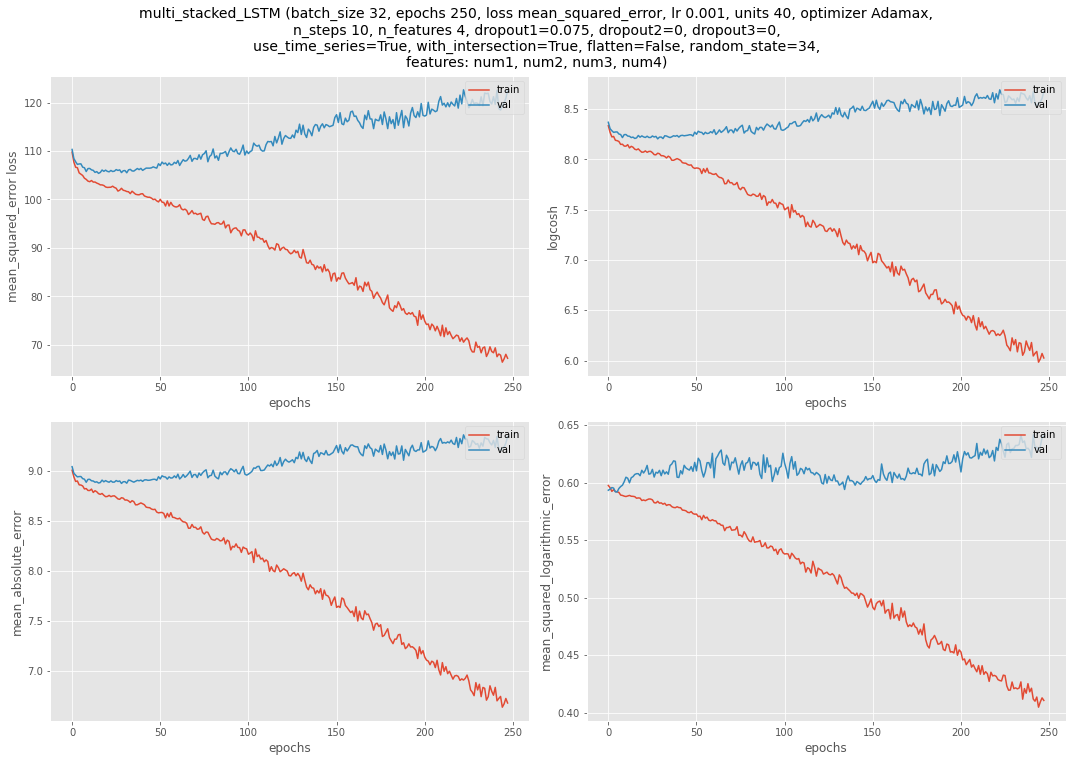

In [24]:
# PLOT RESULTS (Note: ncols & nrows are constant values for all subplots)
optimizer_name = model.optimizer.get_config()['name']
loss_func_name = model.loss.get_config()['name']
metric_names   = [ i.get_config()['name'] for i in model.metrics if i.get_config()['name'] != 'loss']
features_list  = ', '.join(features)

ncols = 2
nrows = (len(metric_names) + 1) // ncols
figure_width  = 15
figure_height = nrows*0.75*(15/ncols) - 0.5
plt.subplots(nrows, ncols, figsize=(figure_width, figure_height))
joint_title = model_name + f' (batch_size {batch_size}, epochs {epochs}, loss {loss_func_name}, ' +\
              f'lr {initial_learning_rate}, units {units}, optimizer {optimizer_name},\nn_steps {n_steps}, ' +\
              f'n_features {n_features}, dropout1={dropout1}, dropout2={dropout2}, dropout3={dropout3},\n' +\
              f'use_time_series={use_time_series}, with_intersection={with_intersection}, ' +\
              f'flatten={flatten}, random_state={random_state},\nfeatures: {features_list})'
                
plt.suptitle( joint_title, fontsize=14 )

# remove very large values in the beginning
start_value = 2

plt.subplot(nrows, ncols, 1)
plt.plot(history.history['loss'][start_value:])
plt.plot(history.history['val_loss'][start_value:])
plt.ylabel(loss_func_name + ' loss')
plt.xlabel('epochs')
plt.legend(['train','val'], loc='upper right')
#plt.show()

for idx, metric_name in enumerate(metric_names):
    plt.subplot(nrows, ncols, idx+2)
    plt.plot(history.history[metric_name][start_value:])
    plt.plot(history.history['val_' + metric_name][start_value:])
    plt.ylabel(metric_name)
    plt.xlabel('epochs')
    plt.legend(['train','val'], loc='upper right')
        
plt.tight_layout()

# save figure
if use_time_series:
    ts_indicator = '_TS_'
else:
    ts_indicator = '_Shuffle_'
timestr   = time.strftime('%Y%m%d-%H%M%S')
folder    = './plots/'
file_name = folder + model_name + '_' + loss_func_name.capitalize() + '_' + optimizer_name + '_' + str(epochs) + '_Epochs' + ts_indicator + timestr + '.jpeg'
plt.savefig(file_name)
 
plt.show()

In [25]:
print( min(history.history['val_loss']) )
min_val = min(history.history['val_loss'])
print(history.history['val_loss'].index(min_val))

105.38433074951172
17


In [26]:
timestr   = time.strftime('%Y%m%d-%H%M%S')
folder    = './models/'
file_name = folder + timestr + '_' + model_name + '_' + loss_func_name.capitalize() + '_' + optimizer_name + '_' + str(epochs) + '_Epochs' + ts_indicator + str(n_steps) + 'n_steps' + '.h5'
model.save(file_name)

# LOAD MODEL
#from keras.models import load_model
#del model
#model = load_model('my_model.h5')

## Predict on last reserved data point and partial train set

In [27]:
# predict
print('Predicting last reserved data point:')
print('True:     ', goldeny)
print('Predicted:', predict_one( model, goldenx ))

Predicting last reserved data point:
True:      [25 27 20 17]
Predicted: [ 8. 25. 23. 12.]


In [28]:
# EVALUATE AND PREDICT ON TRAIN SET
def predict_on_trainset( model, X_, y_ ):
    
    for feature_set, target in zip( X_, y_ ):
        print('True:     ', target)
        print('Predicted:', predict_one( model, feature_set ), '\n', '='*28, sep='')
                
        
# evaluate
print('Evaluating on train set...')
score = model.evaluate( X_train, y_train, verbose=verbose )
print('\nTrain ' + loss_func_name.capitalize() + ':', score[0])
print('Train MSE:    ', score[1], '\n\n', '='*100, '\n', sep='')

# predict
m = 100
print(f'Predicting on last {m} rows of train set:\n')
predict_on_trainset( model, X_train[-m:], y_train[-m:] )

Evaluating on train set...
65/65 [==============================] - 5s 80ms/step - loss: 60.2246 - logcosh: 5.5032 - mean_absolute_error: 6.1535 - mean_squared_logarithmic_error: 0.3544

Train Mean_squared_error: 60.224571228027344
Train MSE:    5.503199100494385


Predicting on last 100 rows of train set:

True:      [19  5  4 28]
Predicted:[13. 20. 19. 16.]
True:      [33 22  3 30]
Predicted:[16. 18. 22. 16.]
True:      [23  2 18  3]
Predicted:[16. 13. 21. 16.]
True:      [23  1 15 29]
Predicted:[10. 13. 17. 15.]
True:      [10  7 18 33]
Predicted:[20. 11. 11. 17.]
True:      [18 13  4 35]
Predicted:[13. 16. 14. 15.]
True:      [27 11 13 32]
Predicted:[11. 17. 16. 11.]
True:      [19 23  5 28]
Predicted:[15. 12. 15. 10.]
True:      [23 24 17 34]
Predicted:[20. 13. 16.  8.]
True:      [30 26  8 20]
Predicted:[23. 13. 18.  9.]
True:      [ 8 30 11  3]
Predicted:[12. 12. 22. 21.]
True:      [ 6 12 19  5]
Predicted:[10. 20. 28. 25.]
True:      [31 18  5  3]
Predicted:[17. 16. 22. 27.]
Tr

Predicted:[17. 19. 13.  7.]
True:      [34 15 12 27]
Predicted:[16. 18. 17. 16.]
True:      [ 7 29 22 26]
Predicted:[11. 21. 19. 11.]
True:      [32  4 30  3]
Predicted:[ 8. 10. 12. 19.]


In [29]:
import gc
gc.collect()

74527

# Appendix

__OPTIMIZERS. IMPORTED TO BE CALLABLE ( Adam(lr=learning_rate) )__  
Using the code below does not make them callable. Each optimizer has also `**kwargs` as a parameter:
* `SGD = tf.keras.optimizers.SGD( learning_rate=0.01, momentum=0.0, nesterov=False, name="SGD" )    # old`
* `RMSprop = tf.keras.optimizers.RMSprop( learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False, name="RMSprop" )`
* `Adagrad = tf.keras.optimizers.Adagrad( learning_rate=0.001, initial_accumulator_value=0.1, epsilon=1e-07,name="Adagrad" )`
* `Adadelta = tf.keras.optimizers.Adadelta( learning_rate=0.001, rho=0.95, epsilon=1e-07, name="Adadelta" )`
* `Adamax = tf.keras.optimizers.Adamax( learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax" )`
* `Adam = tf.keras.optimizers.Adam( learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name="Adam" )`
* `Nadam = tf.keras.optimizers.Nadam( learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam" )`
* `Ftrl = tf.keras.optimizers.Ftrl( learning_rate=0.001, learning_rate_power=-0.5, initial_accumulator_value=0.1, l1_regularization_strength=0.0, l2_regularization_strength=0.0, name="Ftrl", l2_shrinkage_regularization_strength=0.0 )`